In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ast


In [6]:
base_dir = '/Users/siddharthadatta/Library/CloudStorage/OneDrive-Personal/MFE tasks/Capstone project/Project_code/WQU_Capstone_Project/' 
rebalance_file_format = 'forward_index_narrowing_by_rebalance_'
index_cons_with_risk_metrics_file = 'nifty50_cons_with_risk_metrics.csv'
index_values_file = 'nifty50_index_prices_2015_2025.csv'

In [7]:
price_data = pd.read_csv(base_dir + 'all_price_data.csv', parse_dates=['Date'])
price_data['daily_return'] = price_data.groupby('Symbol')['Close'].pct_change()
price_data.dropna(inplace=True)

index_values = pd.read_csv(os.path.join(base_dir, index_values_file))

In [8]:
rebalance_file_dir = Path(os.path.join(base_dir, 'Rebalance files'))
rebalance_file_list = list(rebalance_file_dir.glob("*csv"))

rebalance_data = pd.DataFrame()

for rebal_file in rebalance_file_list:
    rebal_df = pd.read_csv(os.path.join(rebalance_file_dir, rebal_file), usecols= ['rebalance_date', 'k','weights'])
    rebal_df = rebal_df[rebal_df['k'] == max(rebal_df['k'])]
    rebalance_data = pd.concat([rebalance_data, rebal_df])

rebalance_data.sort_values(by = 'rebalance_date')


,rebalance_date,k,weights
8,2016-03-31,9,"{""HDFCBANK"": 0.2668780966604109, ""GRASIM"": 0.0..."
8,2016-09-30,9,"{""HDFCBANK"": 0.29142666387613586, ""KOTAKBANK"":..."
7,2017-03-31,8,"{""HDFCBANK"": 0.3411809566678519, ""KOTAKBANK"": ..."
7,2017-09-30,8,"{""HDFCBANK"": 0.29079515187939237, ""LT"": 0.1598..."
10,2018-03-31,11,"{""HDFCBANK"": 0.22332171402775408, ""MARUTI"": 0...."
10,2018-09-30,11,"{""HDFCBANK"": 0.1690640100543935, ""LT"": 0.13740..."
11,2019-03-31,12,"{""HDFCBANK"": 0.2065617319440926, ""LT"": 0.10838..."
14,2019-09-30,15,"{""HDFCBANK"": 0.18230396248808786, ""LT"": 0.0781..."
21,2020-03-31,22,"{""HDFCBANK"": 0.14479594760094228, ""LT"": 0.0598..."
19,2020-09-30,20,"{""HDFCBANK"": 0.15903799410179073, ""LT"": 0.0809..."


In [10]:

rebalance_data['weights'] = rebalance_data['weights'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Expand the weights dictionary into rows
expanded_rows = []
for _, row in rebalance_data.iterrows():
    date = row['rebalance_date']
    weights_dict = row['weights']
    if isinstance(weights_dict, dict):  # Ensure weights_dict is a dictionary
        for symbol, weight in weights_dict.items():
            expanded_rows.append({
                'Date': date,
                'Symbol': symbol,
                'Weight': weight
            })

# Create the new DataFrame
rebalance_weights_df = pd.DataFrame(expanded_rows)

# Display the resulting DataFrame
rebalance_weights_df.sort_values(by= 'Date')


,Date,Symbol,Weight
185,2016-03-31,HDFCBANK,0.266878
187,2016-03-31,INDUSINDBK,0.059050
188,2016-03-31,TCS,0.143069
186,2016-03-31,GRASIM,0.030268
189,2016-03-31,ACC,0.089507
...,...,...,...
216,2025-09-30,TCS,0.127933
215,2025-09-30,COALINDIA,0.018014
214,2025-09-30,AXISBANK,0.039191
209,2025-09-30,HDFCBANK,0.183050


In [11]:

# ------------------------------------------------------------
# LOAD DATA (already available in your environment)
# ------------------------------------------------------------

# rebalance_weights_df: Date, Symbol, weight
rebalance_weights_df["Date"] = pd.to_datetime(rebalance_weights_df["Date"])

# price_data: Date, Symbol, daily_return
price_data["Date"] = pd.to_datetime(price_data["Date"])

# index_values: Date, Adj Close
index_values["Date"] = pd.to_datetime(index_values["Date"])

# ------------------------------------------------------------
# PREPARE INDEX RETURNS
# ------------------------------------------------------------

index_values = index_values.sort_values("Date")
index_values["index_return"] = np.log(index_values["Adj Close"]).diff()
index_values = index_values.dropna()

# ------------------------------------------------------------
# PREPARE STOCK RETURNS PANEL
# ------------------------------------------------------------

stock_returns = price_data.pivot(
    index="Date",
    columns="Symbol",
    values="daily_return"
)

# ------------------------------------------------------------
# REBALANCE DATES
# ------------------------------------------------------------

rebalance_dates = sorted(rebalance_weights_df["Date"].unique())

# ------------------------------------------------------------
# BUILD PORTFOLIO RETURNS
# ------------------------------------------------------------

portfolio_returns = []

for i, reb_date in enumerate(rebalance_dates):

    # weights at this rebalance
    w = (
        rebalance_weights_df
        .loc[rebalance_weights_df["Date"] == reb_date]
        .set_index("Symbol")["Weight"]
    )

    # start and end dates for holding period
    start_date = reb_date

    if i < len(rebalance_dates) - 1:
        end_date = rebalance_dates[i + 1]
    else:
        end_date = stock_returns.index.max()

    # returns during holding period
    period_returns = stock_returns.loc[start_date:end_date]

    # align symbols
    period_returns = period_returns[w.index]

    # daily portfolio returns
    daily_port_ret = period_returns @ w

    portfolio_returns.append(daily_port_ret)

# ------------------------------------------------------------
# CONCATENATE PORTFOLIO RETURNS
# ------------------------------------------------------------

portfolio_returns = pd.concat(portfolio_returns)
portfolio_returns = portfolio_returns[~portfolio_returns.index.duplicated()]

# ------------------------------------------------------------
# ALIGN WITH INDEX RETURNS
# ------------------------------------------------------------

common_dates = portfolio_returns.index.intersection(index_values["Date"])
portfolio_returns = portfolio_returns.loc[common_dates]

index_returns = (
    index_values
    .set_index("Date")
    .loc[common_dates, "index_return"]
)

# ------------------------------------------------------------
# BUILD INDEX LEVELS (BASE = 100)
# ------------------------------------------------------------

portfolio_cum = portfolio_returns.cumsum()
benchmark_cum = index_returns.cumsum()

portfolio_index = 100 * np.exp(portfolio_cum - portfolio_cum.iloc[0])
benchmark_index = 100 * np.exp(benchmark_cum - benchmark_cum.iloc[0])


# ------------------------------------------------------------
# OUTPUT COMPARISON
# ------------------------------------------------------------

performance_df = pd.DataFrame({
    "Portfolio": portfolio_index,
    "NIFTY50": benchmark_index
})

performance_df.to_csv("portfolio_vs_nifty50_index.csv")

print(performance_df.head())
print("\nFinal values:")
print(performance_df.tail(1))


             Portfolio     NIFTY50
Date                              
2016-03-31  100.000000  100.000000
2016-04-01   99.698685   99.672412
2016-04-04   99.952073  100.263619
2016-04-05   98.507496   98.252873
2016-04-06   99.436705   98.396958

Final values:
             Portfolio     NIFTY50
Date                              
2025-12-30  522.060886  335.196551


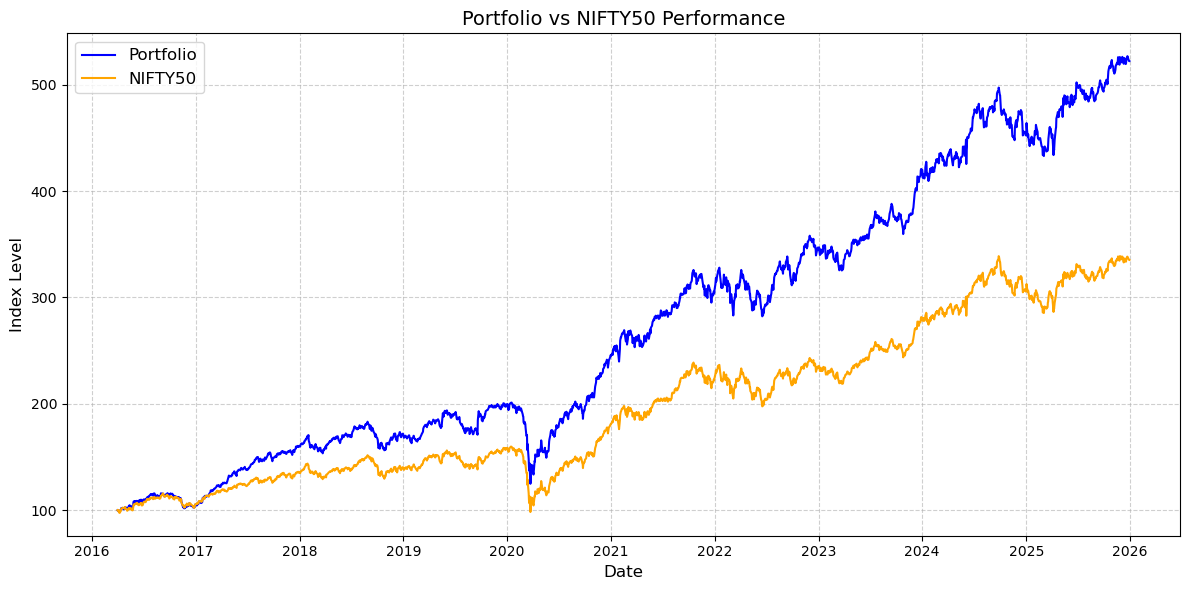

In [12]:
# ------------------------------------------------------------
# PLOT PERFORMANCE COMPARISON
# ------------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(performance_df.index, performance_df['Portfolio'], label='Portfolio', color='blue')
plt.plot(performance_df.index, performance_df['NIFTY50'], label='NIFTY50', color='orange')

plt.title('Portfolio vs NIFTY50 Performance', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index Level', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import pandas as pd

class PortfolioPerformance:
    """
    Evaluate portfolio and benchmark performance.
    Input must be INDEX LEVELS, not returns.
    """

    def __init__(self, performance_df, portfolio_col="Portfolio", benchmark_col="NIFTY50", rf_rate=0.0):
        self.df = performance_df.copy()
        self.portfolio_col = portfolio_col
        self.benchmark_col = benchmark_col
        self.rf_rate = rf_rate

        # Daily log returns
        self.df["portfolio_ret"] = np.log(self.df[portfolio_col]).diff()
        self.df["benchmark_ret"] = np.log(self.df[benchmark_col]).diff()
        self.df = self.df.dropna()

        self.freq = 252

    # --------------------------------------------------------
    # Core metrics
    # --------------------------------------------------------
    def _annualized_return(self, col):
        total_return = self.df[col].iloc[-1] / self.df[col].iloc[0]
        n_years = len(self.df) / self.freq
        return total_return ** (1 / n_years) - 1

    def _volatility(self, ret_col):
        return self.df[ret_col].std() * np.sqrt(self.freq)

    def _sharpe(self, col, ret_col):
        ann_ret = self._annualized_return(col)
        ann_vol = self._volatility(ret_col)
        return (ann_ret - self.rf_rate) / ann_vol

    def tracking_error(self):
        diff = self.df["portfolio_ret"] - self.df["benchmark_ret"]
        return diff.std() * np.sqrt(self.freq)

    def information_ratio(self):
        excess_ret = self.df["portfolio_ret"] - self.df["benchmark_ret"]
        ann_excess = excess_ret.mean() * self.freq
        return ann_excess / self.tracking_error()

    # --------------------------------------------------------
    # Summary table
    # --------------------------------------------------------
    def summary_table(self):
        return pd.DataFrame({
            "Portfolio": [
                self._annualized_return(self.portfolio_col),
                self._volatility("portfolio_ret"),
                self._sharpe(self.portfolio_col, "portfolio_ret"),
                self.tracking_error(),
                self.information_ratio()
            ],
            "Benchmark (NIFTY50)": [
                self._annualized_return(self.benchmark_col),
                self._volatility("benchmark_ret"),
                self._sharpe(self.benchmark_col, "benchmark_ret"),
                np.nan,
                np.nan
            ]
        }, index=[
            "Annualized Return",
            "Volatility",
            "Sharpe Ratio",
            "Tracking Error",
            "Information Ratio"
        ])

    def yearly_max_drawdown(self):
        """
        Compute calendar-year maximum drawdown for portfolio and benchmark.
        """
        data = self.df[[self.portfolio_col, self.benchmark_col]].copy()
        data["Year"] = data.index.year

        def max_drawdown(series):
            cumulative_max = series.cummax()
            drawdown = series / cumulative_max - 1
            return drawdown.min()

        yearly_dd = data.groupby("Year").agg(
            Portfolio_Max_Drawdown=(self.portfolio_col, max_drawdown),
            Benchmark_Max_Drawdown=(self.benchmark_col, max_drawdown)
        )

        return yearly_dd

    # --------------------------------------------------------
    # NEW: Year-wise returns
    # --------------------------------------------------------
    def yearly_returns(self):
        """
        Compute calendar-year returns for portfolio and benchmark.
        """
        yearly = self.df[[self.portfolio_col, self.benchmark_col]].copy()
        yearly["Year"] = yearly.index.year

        year_ret = yearly.groupby("Year").agg(
            Portfolio_Start=(self.portfolio_col, "first"),
            Portfolio_End=(self.portfolio_col, "last"),
            Benchmark_Start=(self.benchmark_col, "first"),
            Benchmark_End=(self.benchmark_col, "last")
        )

        year_ret["Portfolio Return"] = (
            year_ret["Portfolio_End"] / year_ret["Portfolio_Start"] - 1
        )

        year_ret["Benchmark Return"] = (
            year_ret["Benchmark_End"] / year_ret["Benchmark_Start"] - 1
        )

        return year_ret[["Portfolio Return", "Benchmark Return"]]
    
    def monthly_returns(self):
        """
        Compute calendar-month returns for portfolio and benchmark.
        """
        monthly = self.df[[self.portfolio_col, self.benchmark_col]].copy()

        # Create Year-Month key
        monthly["YearMonth"] = monthly.index.to_period("M")

        month_ret = monthly.groupby("YearMonth").agg(
            Portfolio_Start=(self.portfolio_col, "first"),
            Portfolio_End=(self.portfolio_col, "last"),
            Benchmark_Start=(self.benchmark_col, "first"),
            Benchmark_End=(self.benchmark_col, "last")
        )

        month_ret["Portfolio Return"] = (
            month_ret["Portfolio_End"] / month_ret["Portfolio_Start"] - 1
        )

        month_ret["Benchmark Return"] = (
            month_ret["Benchmark_End"] / month_ret["Benchmark_Start"] - 1
        )

        return month_ret[["Portfolio Return", "Benchmark Return"]]



In [33]:
perf = PortfolioPerformance(performance_df)
table = perf.summary_table()

# Pretty formatting
formatted_table = table.copy()
formatted_table.loc[["Annualized Return", "Volatility", "Tracking Error"]] = \
    formatted_table.loc[["Annualized Return", "Volatility", "Tracking Error"]].applymap(
        lambda x: f"{x:.2%}" if pd.notna(x) else ""
    )

formatted_table.loc[["Sharpe Ratio", "Information Ratio"]] = \
    formatted_table.loc[["Sharpe Ratio", "Information Ratio"]].applymap(
        lambda x: f"{x:.3f}" if pd.notna(x) else ""
    )

print(formatted_table)


                  Portfolio Benchmark (NIFTY50)
Annualized Return    18.96%              13.56%
Volatility           16.92%              16.25%
Sharpe Ratio          1.121               0.835
Tracking Error        4.76%                    
Information Ratio     0.977                    


In [29]:
yearly_table = perf.yearly_returns()
formatted_yearly = yearly_table.applymap(lambda x: f"{x:.2%}")
print("\nYearly Returns:")
print(formatted_yearly)


Yearly Returns:
     Portfolio Return Benchmark Return
Year                                  
2016            5.71%            6.13%
2017           51.76%           28.75%
2018            7.19%            4.03%
2019           16.24%           12.75%
2020           23.93%           14.77%
2021           25.20%           23.79%
2022           10.48%            2.72%
2023           21.21%           19.42%
2024            7.76%            8.75%
2025           14.77%            9.25%


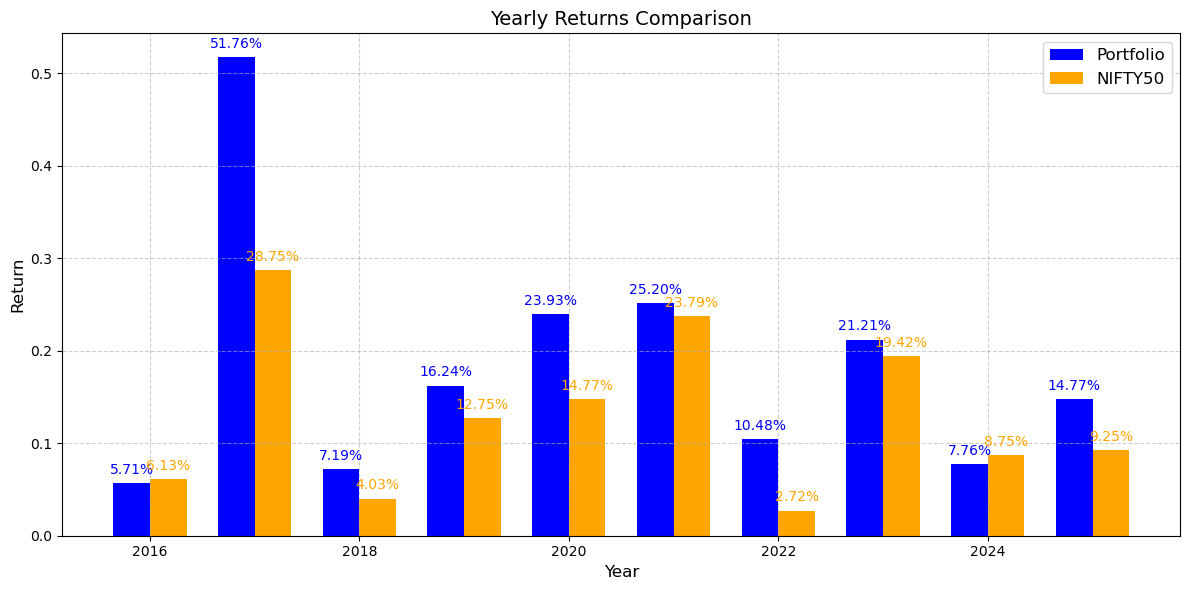

In [34]:
plt.figure(figsize=(12, 6))
x = formatted_yearly.index
width = 0.35  # Width of the bars

# Bar graph for Portfolio and Benchmark Returns
plt.bar(x - width/2, yearly_table['Portfolio Return'], width, label='Portfolio', color='blue')
plt.bar(x + width/2, yearly_table['Benchmark Return'], width, label='NIFTY50', color='orange')

plt.title('Yearly Returns Comparison', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add data labels
for i, v in enumerate(yearly_table['Portfolio Return']):
    plt.text(x[i] - width/2, v + 0.01, f"{v:.2%}", ha='center', fontsize=10, color='blue')

for i, v in enumerate(yearly_table['Benchmark Return']):
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2%}", ha='center', fontsize=10, color='orange')

plt.tight_layout()
plt.show()

In [35]:
monthly_table = perf.monthly_returns()
formatted_monthly = monthly_table.applymap(lambda x: f"{x:.2%}")
print("\nMonthly Returns:")
print(formatted_monthly)


Monthly Returns:
          Portfolio Return Benchmark Return
YearMonth                                  
2016-04              2.92%            1.77%
2016-05              5.71%            4.54%
2016-06              1.67%            1.32%
2016-07              4.50%            3.72%
2016-08              1.00%            1.73%
...                    ...              ...
2025-08             -0.51%           -0.56%
2025-09              1.50%           -0.06%
2025-10              4.29%            3.57%
2025-11              1.59%            1.71%
2025-12             -0.49%           -0.91%

[117 rows x 2 columns]


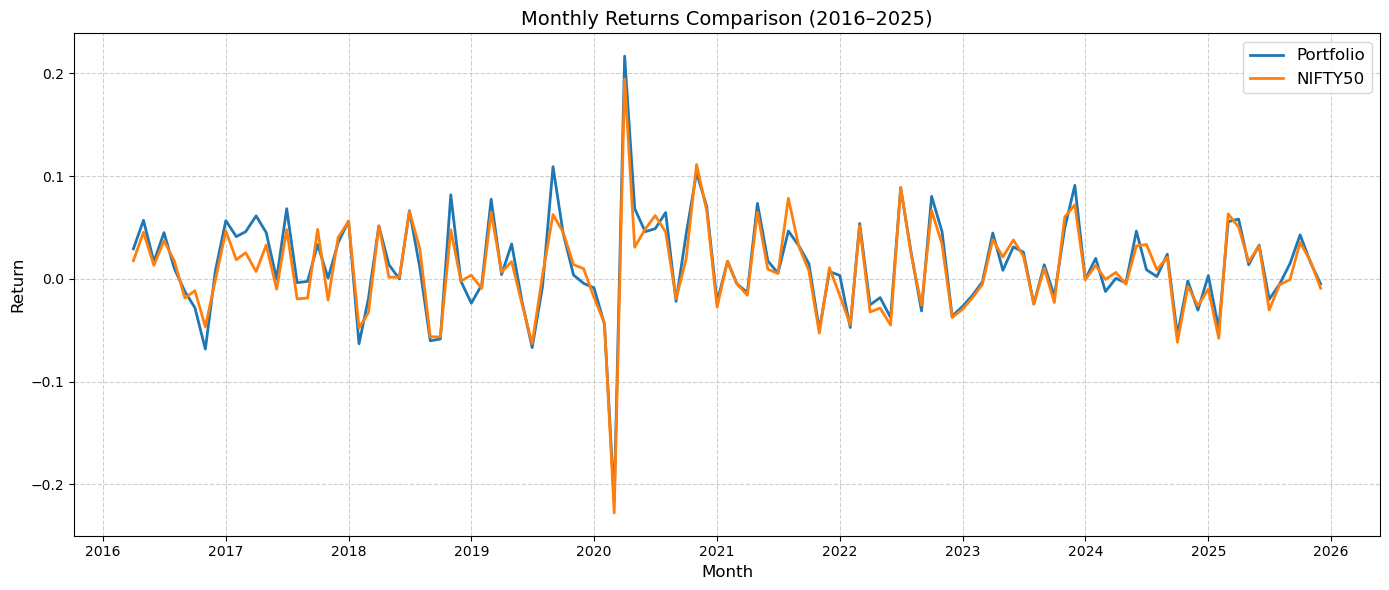

In [36]:

plt.figure(figsize=(14, 6))

plt.plot(
    monthly_table.index.to_timestamp(),
    monthly_table["Portfolio Return"],
    label="Portfolio",
    linewidth=2
)

plt.plot(
    monthly_table.index.to_timestamp(),
    monthly_table["Benchmark Return"],
    label="NIFTY50",
    linewidth=2
)

plt.title("Monthly Returns Comparison (2016–2025)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Return", fontsize=12)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [37]:
yearly_dd = perf.yearly_max_drawdown()


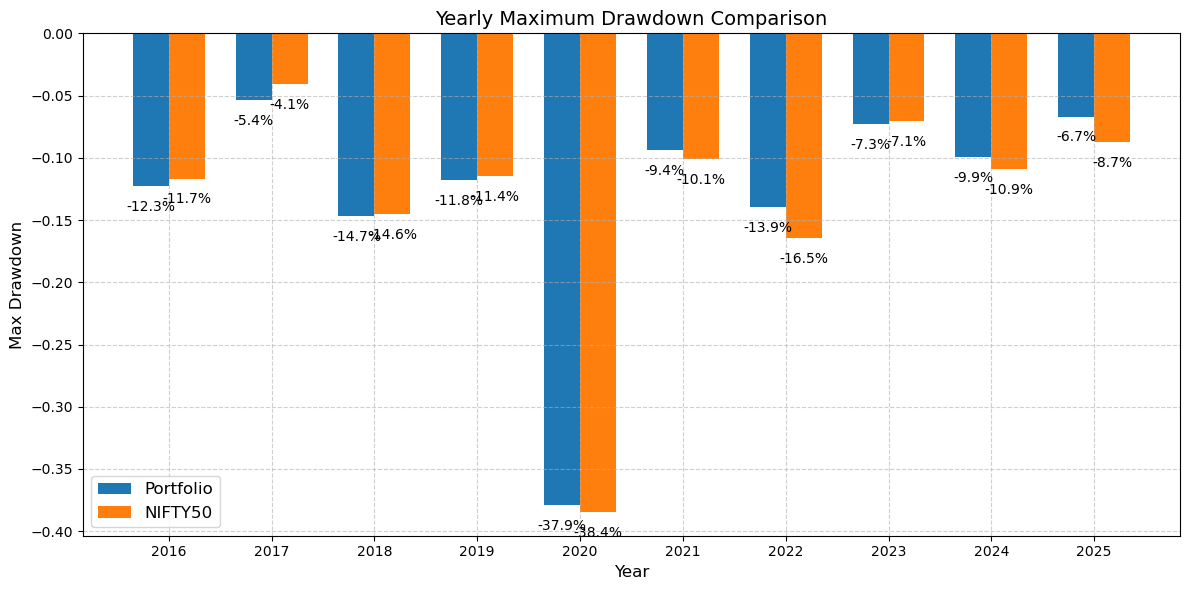

In [38]:
plt.figure(figsize=(12, 6))

x = np.arange(len(yearly_dd.index))
width = 0.35

plt.bar(
    x - width/2,
    yearly_dd["Portfolio_Max_Drawdown"],
    width,
    label="Portfolio"
)

plt.bar(
    x + width/2,
    yearly_dd["Benchmark_Max_Drawdown"],
    width,
    label="NIFTY50"
)

plt.title("Yearly Maximum Drawdown Comparison", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Max Drawdown", fontsize=12)

plt.xticks(x, yearly_dd.index.astype(int))
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Add data labels
for i, v in enumerate(yearly_dd["Portfolio_Max_Drawdown"]):
    plt.text(
        x[i] - width/2,
        v - 0.02,
        f"{v:.1%}",
        ha="center",
        fontsize=10
    )

for i, v in enumerate(yearly_dd["Benchmark_Max_Drawdown"]):
    plt.text(
        x[i] + width/2,
        v - 0.02,
        f"{v:.1%}",
        ha="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()
